In [3]:
from PIL import Image
import os

import matplotlib.pyplot as plt

# Load the image
# Load all image paths from the specified folder
image_folder = r"C:\Users\ma405l\Documents\Heidelberg_Schweregrad\Full_data\Masked_images_test"
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.jpg', '.png'))]
# Filter the specific image path
#image_paths = [path for path in image_paths if "PlatteA_119hpf_pr_2-16_jpg.rf.f4c84d2f272e6ab863b63fddf1370907_mask.jpg" in path]
images = []
for path in image_paths:
    img = Image.open(path)
    initial_size = img.size
    img = img.resize((256,256))  # Downsample the image to 128x128
    images.append(img)

# # Display the downsampled images
# fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
# for ax, img in zip(axes, images):
#     ax.imshow(img, cmap='gray')
#     ax.axis('off')  # Hide axes for better visualization
# plt.show()
# print(initial_size)

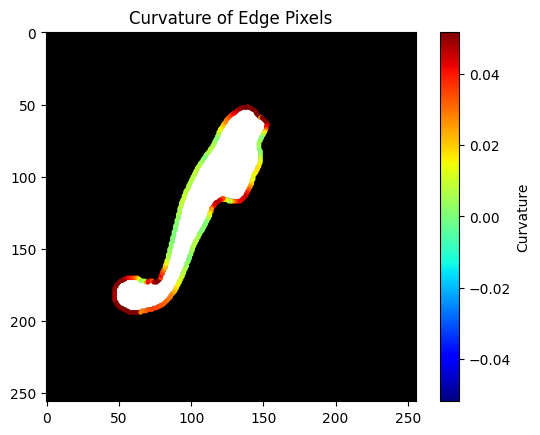

Mean curvature: 0.022814193244878277


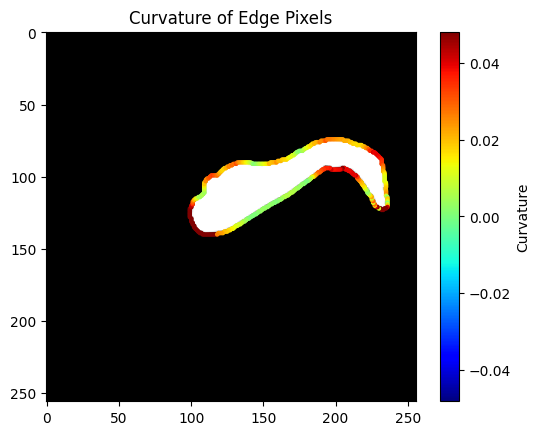

Mean curvature: 0.022142063322903565


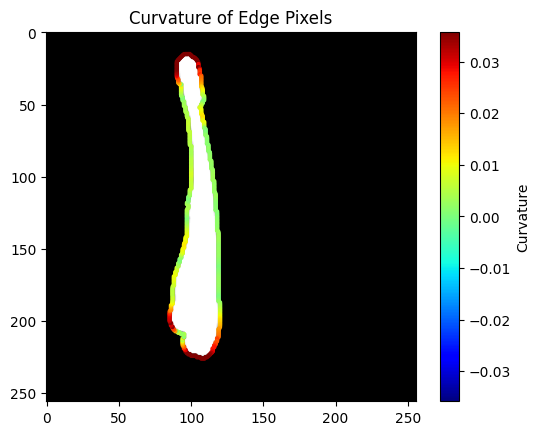

Mean curvature: 0.013137578457217022


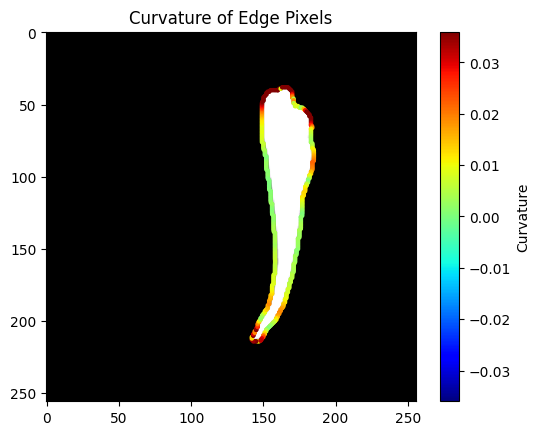

Mean curvature: 0.013342709085325666


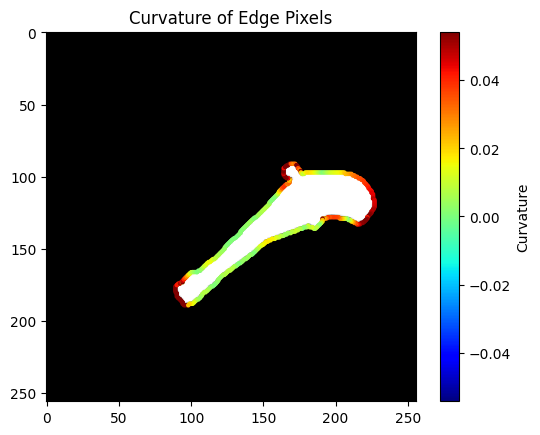

Mean curvature: 0.02191314986235732


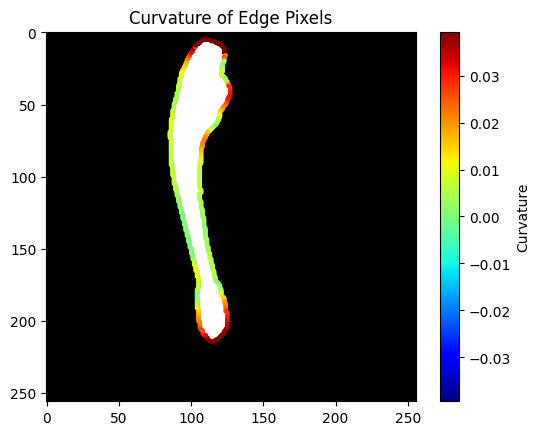

Mean curvature: 0.014232088588391008


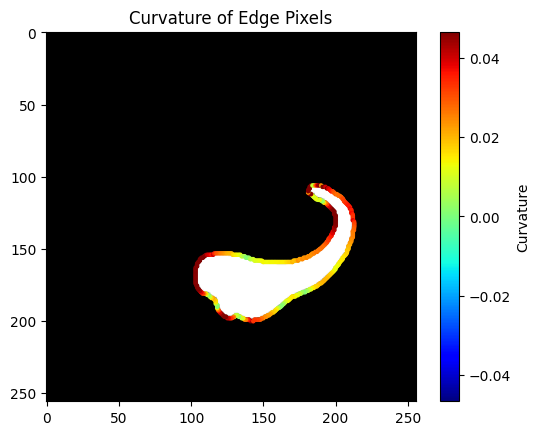

Mean curvature: 0.025891457745631043


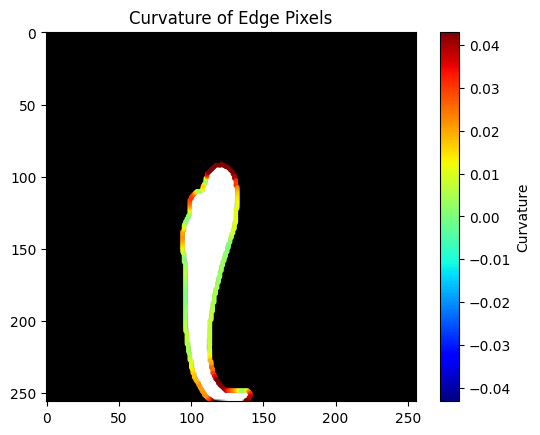

Mean curvature: 0.017084930069535462


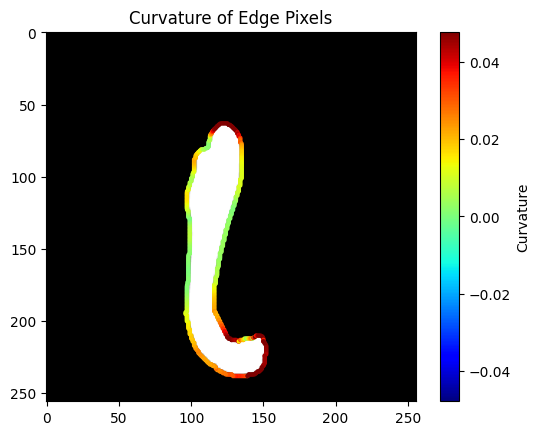

Mean curvature: 0.019965485898328316


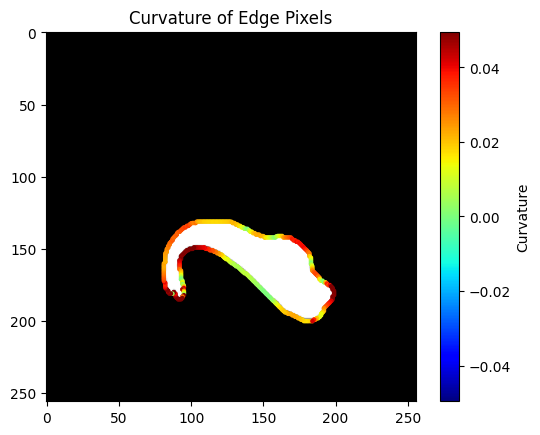

Mean curvature: 0.025892623040513794


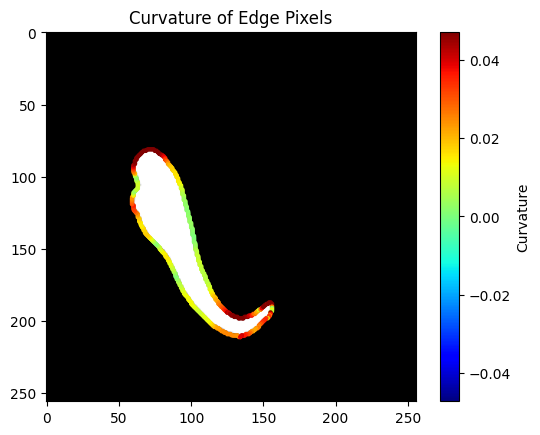

Mean curvature: 0.0210441604456156


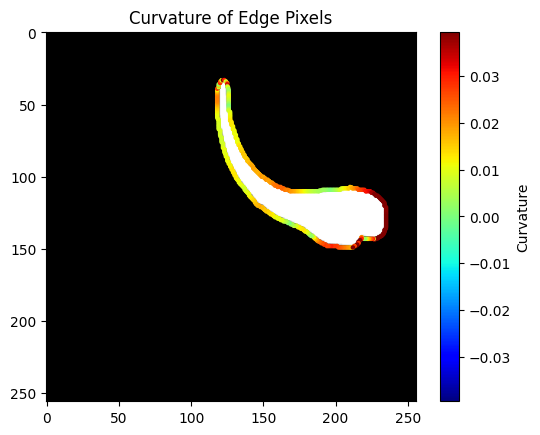

Mean curvature: 0.01819720277146161


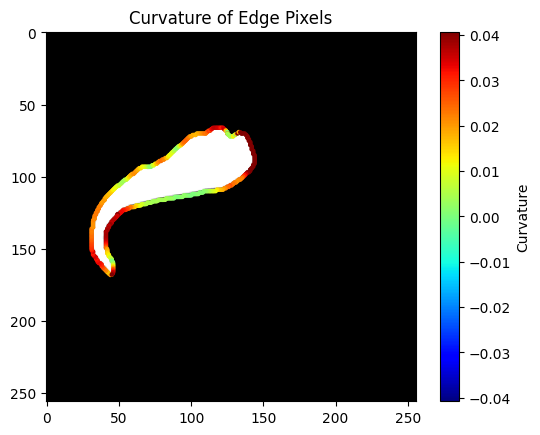

Mean curvature: 0.02157704937465754


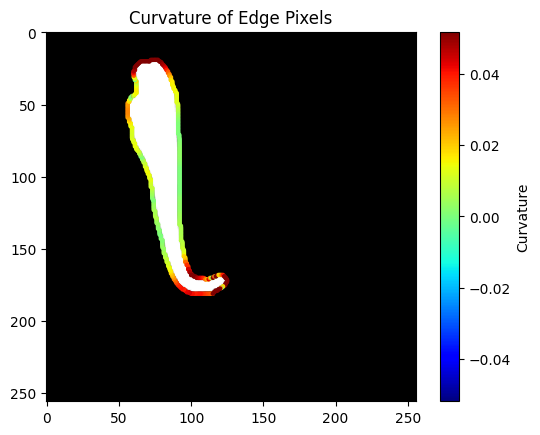

Mean curvature: 0.020942986154130736


In [20]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure

def plot_edges_with_curvature(mask, min_contour_length, window_size_ratio):
    # Compute edge properties
    edge_pixels, curvature_values = compute_curvature_profile(mask, min_contour_length, window_size_ratio)
    plt.imshow(mask, cmap='gray')
    # Plot the mask
    # We set the min and max of the colorbar, so that 90% of the curvature values are shown.
    # This is to have a nice visualization. You can change this threshold according to your specific task.
    threshold = np.percentile(np.abs(curvature_values), 90)
    plt.scatter(edge_pixels[:, 1], edge_pixels[:, 0], c=curvature_values, cmap='jet', s=5, vmin=-threshold, vmax=threshold)

    plt.colorbar(label='Curvature')
    plt.title("Curvature of Edge Pixels")
    plt.show()

    return curvature_values

def compute_curvature_profile(mask, min_contour_length, window_size_ratio):
    # Compute the contours of the mask to be able to analyze each part individually
    contours = measure.find_contours(mask, 0.5)

    # Initialize arrays to store the curvature information for each edge pixel
    curvature_values = []
    edge_pixels = []

    # Iterate over each contour
    for contour in contours:
        # Iterate over each point in the contour
        for i, point in enumerate(contour):
            # We set the minimum contour length to 20
            # You can change this minimum-value according to your specific requirements
            if contour.shape[0] > min_contour_length:
                # Compute the curvature for the point
                # We set the window size to 1/5 of the whole contour edge. Adjust this value according to your specific task
                window_size = int(contour.shape[0]/window_size_ratio)
                curvature = compute_curvature(point, i, contour, window_size)
                # We compute, whether a point is convex or concave.
                # If you want to have the 2nd derivative shown you can comment this part
                # if curvature > 0:
                #     curvature = 1
                # if curvature <= 0:
                #     curvature = -1
                # Store curvature information and corresponding edge pixel
                curvature_values.append(curvature)
                edge_pixels.append(point)

    # Convert lists to numpy arrays for further processing
    curvature_values = np.array(curvature_values)
    edge_pixels = np.array(edge_pixels)

    return edge_pixels, curvature_values
def compute_curvature(point, i, contour, window_size):
    # Compute the curvature using polynomial fitting in a local coordinate system

    # Extract neighboring edge points
    start = max(0, i - window_size // 2)
    end = min(len(contour), i + window_size // 2 + 1)
    neighborhood = contour[start:end]

    # Extract x and y coordinates from the neighborhood
    x_neighborhood = neighborhood[:, 1]
    y_neighborhood = neighborhood[:, 0]

    # Compute the tangent direction over the entire neighborhood and rotate the points
    tangent_direction_original = np.arctan2(np.gradient(y_neighborhood), np.gradient(x_neighborhood))
    tangent_direction_original.fill(tangent_direction_original[len(tangent_direction_original)//2])

    # Translate the neighborhood points to the central point
    translated_x = x_neighborhood - point[1]
    translated_y = y_neighborhood - point[0]


    # Apply rotation to the translated neighborhood points
    # We have to rotate the points to be able to compute the curvature independent of the local orientation of the curve
    rotated_x = translated_x * np.cos(-tangent_direction_original) - translated_y * np.sin(-tangent_direction_original)
    rotated_y = translated_x * np.sin(-tangent_direction_original) + translated_y * np.cos(-tangent_direction_original)

    # Fit a polynomial of degree 2 to the rotated coordinates
    coeffs = np.polyfit(rotated_x, rotated_y, 2)


    # You can compute the curvature using the formula: curvature = |d2y/dx2| / (1 + (dy/dx)^2)^(3/2)
    dy_dx = np.polyval(np.polyder(coeffs), rotated_x)
    d2y_dx2 = np.polyval(np.polyder(coeffs, 2), rotated_x)
    curvature = np.abs(d2y_dx2) / np.power(1 + np.power(dy_dx, 2), 1.5)
    # We compute the 2nd derivative in order to determine whether the curve at the certain point is convex or concave
    #curvature = np.polyval(np.polyder(coeffs, 2), rotated_x)

    # Return the mean curvature for the central point
    return np.mean(curvature)

# Set minimum length of the contours that should be analyzed
min_contour_length = 100
# Set the ratio of the window size (contour length / window_size_ratio) for local polynomial approximation
window_size_ratio = 10

for image in images:
    img = np.array(image)
    curvature = plot_edges_with_curvature(img, min_contour_length, window_size_ratio)
    mean_curvature = np.mean(np.abs(curvature))
    print(f"Mean curvature: {mean_curvature}")


In [2]:
import cv2
import numpy as np


for j, image in enumerate(images):
    image_array = np.array(image)

    # Calculate the maximum and minimum values of the image array
    max_value = np.max(image_array)
    min_value = np.min(image_array)

    print(f"Max value: {max_value}, Min value: {min_value}")
    # Detect edges if not already done

    # Calculate the image width and height
    image_height, image_width = image_array.shape

    # Generate random start and end points for the line within the white part of the image
    # Find the leftmost and rightmost white parts of the image
    white_rows = np.where(np.any(image_array == max_value, axis=1))[0]
    topmost_white = white_rows[0]
    bottommost_white = white_rows[-1]
    white_columns = np.where(np.any(image_array == max_value, axis=0))[0]
    leftmost_white = white_columns[0]
    rightmost_white = white_columns[-1]


    max_distance = 0
    for random_y1 in white_rows[::2]:  # Skip every second point in rows
        for random_x1 in white_columns[::2]:  # Skip every second point in columns
            if image_array[random_y1, random_x1] > 0:
                for random_y2 in white_rows[::2]:  # Skip every second point in rows
                    for random_x2 in white_columns[::2]:  # Skip every second point in columns
                        if image_array[random_y2, random_x2] > 0:
                            if image_array[random_y1, random_x1] == 0 or image_array[random_y2, random_x2] == 0:
                                continue
                            distance = np.hypot(
                                (random_x2 - random_x1) * (initial_size[0] / 256),
                                (random_y2 - random_y1) * (initial_size[1] / 256)
                            )
                            if distance > max_distance:
                                max_distance = distance
                                x1, y1 = random_x1, random_y1
                                x2, y2 = random_x2, random_y2
                


    result_image = cv2.cvtColor(image_array.copy(), cv2.COLOR_GRAY2BGR)

    mid_point=(0,0)
    max_curve_length = np.inf


    found_valid_curve = False
    # Add a variable to indicate whether it's a curve with one, two, or no midpoints
    curve_type = "none"  # Default value

    # Try without any midpoint first
    temp_curve_x = np.linspace(x1, x2, 100, dtype=int)
    temp_curve_y = np.linspace(y1, y2, 100, dtype=int)

    if (
        image_array[temp_curve_y, temp_curve_x].all() > 0
    ):
        curve_length = np.hypot(
            np.diff(temp_curve_x) * (initial_size[0] / 256),
            np.diff(temp_curve_y) * (initial_size[1] / 256)
        ).sum()

        if curve_length < max_curve_length:
            max_curve_length = curve_length
            curve_x = temp_curve_x
            curve_y = temp_curve_y
            mid_point1 = None
            mid_point2 = None
            found_valid_curve = True
            curve_type = "no_midpoint"

    # If no valid curve is found without a midpoint, try with one midpoint
    # if not found_valid_curve:
    #     for mid_y1 in range(topmost_white, bottommost_white):
    #         for mid_x1 in range(leftmost_white, rightmost_white):
    #             if image_array[mid_y1, mid_x1] > 0:
    #                 temp_curve_x1 = np.linspace(x1, mid_x1, 100, dtype=int)
    #                 temp_curve_y1 = np.linspace(y1, mid_y1, 100, dtype=int)
    #                 temp_curve_x2 = np.linspace(mid_x1, x2, 100, dtype=int)
    #                 temp_curve_y2 = np.linspace(mid_y1, y2, 100, dtype=int)

    #                 if (
    #                     image_array[temp_curve_y1, temp_curve_x1].all() > 0 and
    #                     image_array[temp_curve_y2, temp_curve_x2].all() > 0
    #                 ):
    #                     curve1_distance = np.sum(np.sqrt(np.diff(temp_curve_x1)**2 + np.diff(temp_curve_y1)**2))
    #                     curve2_distance = np.sum(np.sqrt(np.diff(temp_curve_x2)**2 + np.diff(temp_curve_y2)**2))
    #                     curve_length = curve1_distance + curve2_distance

    #                     if curve_length < max_curve_length:
    #                         max_curve_length = curve_length
    #                         curve_x1 = temp_curve_x1
    #                         curve_y1 = temp_curve_y1
    #                         curve_x2 = temp_curve_x2
    #                         curve_y2 = temp_curve_y2
    #                         mid_point1 = (mid_x1, mid_y1)
    #                         mid_point2 = None
    #                         found_valid_curve = True
    #                         curve_type = "one_midpoint"
    #                         break
    #         if found_valid_curve:
    #             break

    # If no valid curve is found with one midpoint, try with two midpoints
    if not found_valid_curve:
        print("No valid curve with one midpoint found. Trying with two midpoints.")
        # Use numpy broadcasting to generate all combinations of midpoints
        mid_y1, mid_x1 = np.meshgrid(
            np.arange(topmost_white, bottommost_white, 4),
            np.arange(leftmost_white, rightmost_white, 4),
            indexing='ij'
        )
        mid_y2, mid_x2 = np.meshgrid(
            np.arange(topmost_white, bottommost_white, 4),
            np.arange(leftmost_white, rightmost_white, 4),
            indexing='ij'
        )

        # Flatten the arrays for easier iteration
        mid_y1 = mid_y1.ravel()
        mid_x1 = mid_x1.ravel()
        mid_y2 = mid_y2.ravel()
        mid_x2 = mid_x2.ravel()

        # Iterate over all combinations of midpoints
        for i in range(len(mid_y1)):
            if image_array[mid_y1[i], mid_x1[i]] > 0:
                for j in range(len(mid_y2)):
                    if image_array[mid_y2[j], mid_x2[j]] > 0:
                        temp_curve_x1 = np.linspace(x1, mid_x1[i], 50, dtype=int)
                        temp_curve_y1 = np.linspace(y1, mid_y1[i], 50, dtype=int)
                        temp_curve_x2 = np.linspace(mid_x1[i], mid_x2[j], 50, dtype=int)
                        temp_curve_y2 = np.linspace(mid_y1[i], mid_y2[j], 50, dtype=int)
                        temp_curve_x3 = np.linspace(mid_x2[j], x2, 50, dtype=int)
                        temp_curve_y3 = np.linspace(mid_y2[j], y2, 50, dtype=int)

                        if (
                            image_array[temp_curve_y1, temp_curve_x1].all() > 0 and
                            image_array[temp_curve_y2, temp_curve_x2].all() > 0 and
                            image_array[temp_curve_y3, temp_curve_x3].all() > 0
                        ):
                            curve1_distance = np.hypot(
                                np.diff(temp_curve_x1) * (initial_size[0] / 256),
                                np.diff(temp_curve_y1) * (initial_size[1] / 256)
                            ).sum()
                            curve2_distance = np.hypot(
                                np.diff(temp_curve_x2) * (initial_size[0] / 256),
                                np.diff(temp_curve_y2) * (initial_size[1] / 256)
                            ).sum()
                            curve3_distance = np.hypot(
                                np.diff(temp_curve_x3) * (initial_size[0] / 256),
                                np.diff(temp_curve_y3) * (initial_size[1] / 256)
                            ).sum()
                            curve_length = curve1_distance + curve2_distance + curve3_distance

                            if curve_length < max_curve_length:
                                max_curve_length = curve_length
                                curve_x1 = temp_curve_x1
                                curve_y1 = temp_curve_y1
                                curve_x2 = temp_curve_x2
                                curve_y2 = temp_curve_y2
                                curve_x3 = temp_curve_x3
                                curve_y3 = temp_curve_y3
                                mid_point1 = (mid_x1[i], mid_y1[i])
                                mid_point2 = (mid_x2[j], mid_y2[j])
                                found_valid_curve = True
                                curve_type = "two_midpoints"
                            # if image_array[mid_y2, mid_x2] > 0:
                            #     temp_curve_x1 = np.linspace(x1, mid_x1, 20, dtype=int)
                            #     temp_curve_y1 = np.linspace(y1, mid_y1, 20, dtype=int)
                            #     temp_curve_x2 = np.linspace(mid_x1, mid_x2, 20, dtype=int)
                            #     temp_curve_y2 = np.linspace(mid_y1, mid_y2, 20, dtype=int)
                            #     temp_curve_x3 = np.linspace(mid_x2, x2, 20, dtype=int)
                            #     temp_curve_y3 = np.linspace(mid_y2, y2, 20, dtype=int)

                            #     if (
                            #         image_array[temp_curve_y1, temp_curve_x1].all() > 0 and
                            #         image_array[temp_curve_y2, temp_curve_x2].all() > 0 and
                            #         image_array[temp_curve_y3, temp_curve_x3].all() > 0
                            #     ):
                            #         curve1_distance = np.sum(np.sqrt(np.diff(temp_curve_x1)**2 + np.diff(temp_curve_y1)**2))
                            #         curve2_distance = np.sum(np.sqrt(np.diff(temp_curve_x2)**2 + np.diff(temp_curve_y2)**2))
                            #         curve3_distance = np.sum(np.sqrt(np.diff(temp_curve_x3)**2 + np.diff(temp_curve_y3)**2))
                            #         curve_length = curve1_distance + curve2_distance + curve3_distance

                            #         if curve_length < max_curve_length:
                            #             max_curve_length = curve_length
                            #             curve_x1 = temp_curve_x1
                            #             curve_y1 = temp_curve_y1
                            #             curve_x2 = temp_curve_x2
                            #             curve_y2 = temp_curve_y2
                            #             curve_x3 = temp_curve_x3
                            #             curve_y3 = temp_curve_y3
                            #             mid_point1 = (mid_x1, mid_y1)
                            #             mid_point2 = (mid_x2, mid_y2)
                            #             found_valid_curve = True
                            #             curve_type = "two_midpoints"
                                        
                        

                        
                  
    
    # # Generate points for a non-straight line (e.g., quadratic curve)
    # curve_x = np.linspace(x1, x2, 200, dtype=int)
    # curve_y = np.linspace(y1, y2, 200, dtype=int)  

    # max_curve_length = np.inf

    # max_coeff=0.5
    # for m1 in np.linspace(-1*max_coeff, max_coeff, 200):
    #     for m2 in np.linspace(-1*max_coeff, max_coeff, 200):
            
    #         temp_curve_y = curve_y + m1 * (curve_y - curve_y[0]) * (curve_y[-1] - curve_y)
    #         temp_curve_x = curve_x + m2 * (curve_x - curve_x[0]) * (curve_x[-1] - curve_x)
    #         temp_curve_x = temp_curve_x.astype(int)
    #         temp_curve_y = temp_curve_y.astype(int)
    #         # Check if the curve is completely inside the white area
    #         if np.all((temp_curve_x >= 0) & (temp_curve_x < image_width) &
    #                 (temp_curve_y >= 0) & (temp_curve_y < image_height)):
                
    #             if np.all((temp_curve_x >= leftmost_white) & (temp_curve_x <= rightmost_white) &
    #                 (temp_curve_y >= topmost_white) & (temp_curve_y <= bottommost_white)):
    #                 if (np.min(image_array[temp_curve_y, temp_curve_x]) > 0):
    #                     curve_length = np.sum(np.sqrt(np.diff(temp_curve_x)**2 + np.diff(temp_curve_y)**2))
    #                     if curve_length < max_curve_length:
    #                         max_curve_length = curve_length
    #                         curve_y = temp_curve_y
    #                         curve_x = temp_curve_x
                            
    #     else:
    #         continue
    #     break



    # Draw the curve on the result image
    # Draw the curve from point1 to the midpoint
    if curve_type == "no_midpoint":
        # Draw the curve from point1 to point2
        for i in range(len(curve_x) - 1):
            cv2.line(result_image, (curve_x[i], curve_y[i]), (curve_x[i + 1], curve_y[i + 1]), (255, 0, 0), thickness=1)

    elif curve_type == "one_midpoint":
        # Draw the curve from point1 to the midpoint
        for i in range(len(curve_x1) - 1):
            cv2.line(result_image, (curve_x1[i], curve_y1[i]), (curve_x1[i + 1], curve_y1[i + 1]), (255, 0, 0), thickness=1)

        # Draw the curve from the midpoint to point2
        for i in range(len(curve_x2) - 1):
            cv2.line(result_image, (curve_x2[i], curve_y2[i]), (curve_x2[i + 1], curve_y2[i + 1]), (0, 255, 0), thickness=1)

    elif curve_type == "two_midpoints":
        # Draw the curve from point1 to the first midpoint
        for i in range(len(curve_x1) - 1):
            cv2.line(result_image, (curve_x1[i], curve_y1[i]), (curve_x1[i + 1], curve_y1[i + 1]), (255, 0, 0), thickness=1)

        # Draw the curve from the first midpoint to the second midpoint
        for i in range(len(curve_x2) - 1):
            cv2.line(result_image, (curve_x2[i], curve_y2[i]), (curve_x2[i + 1], curve_y2[i + 1]), (0, 255, 0), thickness=1)

        # Draw the curve from the second midpoint to point2
        for i in range(len(curve_x3) - 1):
            cv2.line(result_image, (curve_x3[i], curve_y3[i]), (curve_x3[i + 1], curve_y3[i + 1]), (0, 0, 255), thickness=1)
    # Save the result
    output_folder = r"C:\Users\ma405l\Documents\Heidelberg_Schweregrad\Full_data\Masked_images_test_line"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    output_path = os.path.join(output_folder, f"result_image_{j + 1}.png")
    #result_image = cv2.resize(result_image, (256, 256), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(output_path, result_image)
    print(f"Saved result image to {output_path}")
    print(f"Curve length: {max_distance}")
    # Display the result image with the drawn curve
    plt.imshow(result_image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()


NameError: name 'images' is not defined